In [25]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Machine learning preprocessing and model selection
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Machine learning models
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold

# XGBoost
from xgboost import XGBClassifier, XGBRFClassifier

# Additional Tools
import shap
from category_encoders.ordinal import OrdinalEncoder


## Previewing the Data Collected in 2016
In total, there are 1433 participants who volunteered to take the survey that involves 63 questions. 

Participants who are self-employed were required to answer less questions compared to those who are not self-employed. Due to the reason that I am interested in comparing the association between self-employment and mental health, the reponses that include lots of empty value would not be removed to ensure that the group of self-employed will be included in data analysis. 

In [26]:
# View the summary of numerical variables
data_2016 = pd.read_csv("../data/OSMI_data_2016.csv")
data_2016.describe()

,Are you self-employed?,Is your employer primarily a tech company/organization?,Is your primary role within your company related to tech/IT?,Do you have medical coverage (private insurance or state-provided) which includes treatment of mental health issues?,Do you have previous employers?,Have you ever sought treatment for a mental health issue from a mental health professional?,What is your age?
count,1433.000000,1146.000000,263.000000,287.000000,1433.000000,1433.000000,1433.000000
mean,0.200279,0.770506,0.942966,0.644599,0.882066,0.585485,34.286113
std,0.400349,0.420691,0.232350,0.479471,0.322643,0.492810,11.290931
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,28.000000
50%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,33.000000
75%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,39.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,323.000000


In [27]:
# View the summary of categorical variables
data_2016.describe(include=['O'])


,How many employees does your company or organization have?,Does your employer provide mental health benefits as part of healthcare coverage?,Do you know the options for mental health care available under your employer-provided coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Does your employer offer resources to learn more about mental health concerns and options for seeking help?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,"If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",Do you think that discussing a mental health disorder with your employer would have negative consequences?,Do you think that discussing a physical health issue with your employer would have negative consequences?,Would you feel comfortable discussing a mental health disorder with your coworkers?,...,"If so, what condition(s) were you diagnosed with?","If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?","If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?",What is your gender?,What country do you live in?,What US state or territory do you live in?,What country do you work in?,What US state or territory do you work in?,Which of the following best describes your work position?,Do you work remotely?
count,1146,1146,1013,1146,1146,1146,1146,1146,1146,1146,...,711,1433,1433,1430,1433,840,1433,851,1433,1433
unique,6,4,3,3,3,3,6,3,3,3,...,116,5,5,70,53,47,53,48,264,3
top,26-100,Yes,No,No,No,I don't know,Somewhat easy,Maybe,No,Maybe,...,"Mood Disorder (Depression, Bipolar Disorder, etc)",Not applicable to me,Often,Male,United States of America,California,United States of America,California,Back-end Developer,Sometimes
freq,292,531,354,813,531,742,281,487,837,479,...,187,557,538,610,840,130,851,141,263,757


In [28]:
counts = data_2016['Do you currently have a mental health disorder?'].value_counts()

# Print the counts
print(counts)

Do you currently have a mental health disorder?
Yes      575
No       531
Maybe    327
Name: count, dtype: int64


## Pre-processing the Data
At this step, I will clean the data to prepare for data analysis. 

1. Gender: As there are many different expressions of gender, they will be labeled for consistency. 
2. Age: There are several values that are not normal, such as more than hundred. Therefore, mean imputation will be taken. 
3. Country: Recode some of the country names to be more concise.

In [29]:
# Data cleaning

# Column rename
columns_new_names = [
    'self_employment_flag', 'company_size', 'tech_company_flag', 'tech_role_flag', 'mental_health_coverage_flag',
    'mental_health_coverage_awareness_flag', 'employer_discussion_flag', 'resources_provided_flag', 'anonymity_flag',
    'medical_leave_flag', 'discussion_negative_impact_flag', 'physical_health_discussion_negative_impact_flag', 
    'coworker_discussion_flag', 'supervisor_discussion_flag', 'employer_equal_mental_physical_health_flag', 
    'coworker_consequences_flag', 'mental_health_coverage_flag2', 'online_resources_flag', 
    'diagnosed_reveal_clients_flag', 'diagnosed_reveal_clients_impact', 'diagnosed_reveal_coworker_flag', 
    'coworker_reveal_negative_impact', 'productivity_impact', 'productivity_impact_percentage', 
    'previous_employers_flag', 'previous_mental_health_benefits', 'previous_mental_health_benefits_awareness', 
    'previous_mental_health_discussion', 'previous_resources', 'previous_anonymity_flag', 
    'previous_discussion_negative_consequences', 'previous_physical_health_discussion_negative_consequences', 
    'previous_coworker_discussion_flag', 'previous_supervisor_discussion_flag', 
    'previous_employer_importance_mental_health', 'previous_coworker_consequences', 'future_physical_health_specification', 
    'why', 'future_mental_health_specification', 'why2', 'mental_health_career_impact', 
    'negative_view_coworkers', 'sharing_with_friends_family_flag', 'bad_response_workplace', 
    'bad_response_others_workplace', 'family_history_mental_health', 'past_mental_disorder', 
    'current_mental_disorder', 'diagnosis_details', 'possible_diagnosis', 'diagnosis_by_professional', 
    'condition_diagnosed_flag', 'sought_professional_treatment', 'effective_treatment_impact_on_work', 
    'ineffective_treatment_impact_on_work', 'age', 'sex', 'country_of_residence', 'residence_in_us_territory', 
    'country_of_work', 'work_in_us_territory', 'work_position', 'remote_work_flag'
]
data_2016.columns = columns_new_names

# Recode the sex column into three categories: male, female, and other
male_identifiers = ['Male', 'male', 'Male ', 'M', 'm', 'man', 'Cis male', 'Male.', 'male 9:1 female, roughly', 
                    'Male (cis)', 'Man', 'Sex is male', 'cis male', 'Malr', 'Dude', 
                    "I'm a man why didn't you make this a drop down question. You should of asked sex? And I would of answered yes please. Seriously how much text can this take? ",
                    'mail', 'M|', 'Male/genderqueer', 'male ', 'Cis Male', 'Male (trans, FtM)', 
                    'cisdude', 'cis man', 'MALE']
female_identifiers = ['Female', 'female', 'I identify as female.', 'female ', 'Female assigned at birth ', 'F', 
                      'Woman', 'fm', 'f', 'Cis female ', 'Transitioned, M2F', 'Genderfluid (born female)', 
                      'Female or Multi-Gender Femme', 'Female ', 'woman', 'female/woman', 'Cisgender Female', 
                      'fem', 'Female (props for making this a freeform field, though)', ' Female', 'Cis-woman', 
                      'female-bodied; no feelings about gender', 'AFAB']
other_identifiers = ['Bigender', 'non-binary', 'Other/Transfeminine', 'Androgynous', 'Other', 'nb masculine', 
                     'none of your business', 'genderqueer', 'Human', 'Genderfluid', 'Enby', 'genderqueer woman', 
                     'mtf', 'Queer', 'Agender', 'Fluid', 'Nonbinary', 'human', 'Unicorn', 'Genderqueer', 
                     'Genderflux demi-girl', 'Transgender woman']

data_2016['sex'].replace(to_replace=male_identifiers, value=1, inplace=True)
data_2016['sex'].replace(to_replace=female_identifiers, value=2, inplace=True)
data_2016['sex'].replace(to_replace=other_identifiers, value=3, inplace=True)

# Mean imputation for age column
age_mean = data_2016[(data_2016['age'] >= 16) & (data_2016['age'] <= 75)]['age'].mean()
data_2016.loc[(data_2016['age'] < 16) | (data_2016['age'] > 75), 'age'] = age_mean
data_2016['age'] = data_2016['age'].astype(int)

# Recode company size and country name columns
data_2016['company_size'].replace(to_replace=['More than 1000'], value='>1000', inplace=True)
data_2016['country_of_residence'].replace(to_replace=['United States of America'], value='USA', inplace=True)
data_2016['country_of_residence'].replace(to_replace=['United Kingdom'], value='UK', inplace=True)
data_2016['country_of_work'].replace(to_replace=['United States of America'], value='USA', inplace=True)
data_2016['country_of_work'].replace(to_replace=['United Kingdom'], value='UK', inplace=True)

# Delete irrevelant value in the 'company_size' column
data_2016['company_size'].replace(to_replace=['01/06/2025', '01/05/2024'], value=pd.NA, inplace=True)

# View the cleaned data
#rint(data_2016.head())
#print(data_2016.info())
#print(data_2016.describe())
#print(data_2016.isnull().sum())
#display(data_2016)


C:\Users\daiym\AppData\Local\Temp\ipykernel_3060\1049886710.py:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_2016['sex'].replace(to_replace=male_identifiers, value=1, inplace=True)
C:\Users\daiym\AppData\Local\Temp\ipykernel_3060\1049886710.py:45: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

In [66]:
print(age_mean)

34.074177746676


In [30]:
counts = data_2016['current_mental_disorder'].value_counts()

# Print the counts
print(counts)

current_mental_disorder
Yes      575
No       531
Maybe    327
Name: count, dtype: int64


In [31]:
countries = data_2016['country_of_work'].value_counts()
print(countries)

country_of_work
USA                       851
UK                        183
Canada                     74
Germany                    58
Netherlands                47
Australia                  34
Sweden                     20
Ireland                    15
France                     14
Switzerland                10
Brazil                     10
India                       9
Russia                      9
New Zealand                 9
Denmark                     7
Bulgaria                    7
Finland                     7
Belgium                     5
South Africa                4
Poland                      4
Austria                     4
Czech Republic              3
Italy                       3
Chile                       3
Norway                      3
Romania                     3
Spain                       3
Other                       2
Bosnia and Herzegovina      2
Afghanistan                 2
Pakistan                    2
Israel                      2
Estonia                 

In [32]:
imputer = SimpleImputer(strategy='most_frequent')
imputed_data = pd.DataFrame(imputer.fit_transform(data_2016), columns=data_2016.columns)

# Split the data into parts that need encoding and parts that do not
columns_for_encoding = [col for col in imputed_data.columns if col not in ['age', 'why', 'why2', 'country_of_residence',
       'residence_in_us_territory', 'country_of_work', 'work_in_us_territory', 'work_position', 'current_mental_disorder']]

data_for_encoding = imputed_data[columns_for_encoding]
data_without_encoding = imputed_data[['age', 'why', 'why2', 'country_of_residence',
       'residence_in_us_territory', 'country_of_work', 'work_in_us_territory', 'work_position', 'current_mental_disorder']]

# Encode categorical data
def encode_data(data):
    categorical_columns = list(data.select_dtypes(include=['object']))
    
    # Initialize the encoders
    onehot_encoder = OneHotEncoder(sparse=False, drop='first')  # drop='first' to avoid dummy variable trap
    onehot_encoded = onehot_encoder.fit_transform(data[categorical_columns])
    onehot_encoded_df = pd.DataFrame(onehot_encoded, columns=onehot_encoder.get_feature_names_out(categorical_columns))
    
    # Drop the original categorical columns from data and add the new one-hot encoded columns
    data = data.drop(columns=categorical_columns)
    data = pd.concat([data, onehot_encoded_df], axis=1)
    
    return data

# Encode the data
encoded_df = encode_data(data_for_encoding)

# Combine the encoded data with the non-encoded data
combined_data = pd.concat([encoded_df, data_without_encoding], axis=1)

# Ensure 'current_mental_disorder' is encoded as a single column suitable for modeling
label_encoder = LabelEncoder()
combined_data['current_mental_disorder'] = label_encoder.fit_transform(combined_data['current_mental_disorder'])


# Filtering countries with more responses
filtered_countries = ['USA', 'UK', 'Canada', 'Germany', 'Netherlands', 'Australia', 'Sweden', 'Ireland', 'France']
imputed_data = imputed_data[imputed_data['country_of_work'].isin(filtered_countries)]
imputed_data = imputed_data[imputed_data['country_of_residence'].isin(filtered_countries)]

combined_data = combined_data[combined_data['country_of_work'].isin(filtered_countries)]
combined_data = combined_data[combined_data['country_of_residence'].isin(filtered_countries)]

# Handle missing values in the tech-related flag
# Identify tech-related work positions
tech_positions = []
tech_positions.extend(imputed_data[imputed_data['work_position'].str.contains('Back-end')]['work_position'].tolist())
tech_positions.extend(imputed_data[imputed_data['work_position'].str.contains('Front-end')]['work_position'].tolist())
tech_positions.extend(imputed_data[imputed_data['work_position'].str.contains('Dev')]['work_position'].tolist())
tech_positions.extend(imputed_data[imputed_data['work_position'].str.contains('DevOps')]['work_position'].tolist())

# Flatten the list and remove duplicates
unique_tech_positions = list(set(tech_positions))

# Create a new column to mark tech-related roles
imputed_data['tech_flag'] = imputed_data['work_position']
imputed_data['tech_flag'].replace(to_replace=unique_tech_positions, value=1, inplace=True)

# Mark non-tech roles with 0
imputed_data['tech_flag'].replace(to_replace=list(set(imputed_data['work_position']) - set(unique_tech_positions)), value=0, inplace=True)
# Filter out self-employed individuals
workplace_data = imputed_data[imputed_data['self_employment_flag'] == 0]

# Apply the same logic to the noncoded_df
combined_data['tech_flag'] = combined_data['work_position']
combined_data['tech_flag'].replace(to_replace=unique_tech_positions, value=1, inplace=True)
combined_data['tech_flag'].replace(to_replace=list(set(combined_data['work_position']) - set(unique_tech_positions)), value=0, inplace=True)


C:\Users\daiym\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\daiym\AppData\Local\Temp\ipykernel_3060\1963116092.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  imputed_data['tech_flag'].replace(to_replace=uniqu

In [33]:
counts = combined_data['current_mental_disorder'].value_counts()

# Print the counts
print(counts)

print(label_encoder.classes_)

current_mental_disorder
2    540
1    460
0    285
Name: count, dtype: int64
['Maybe' 'No' 'Yes']


## Descriptive Data


### Age and Gender Distribution

In [34]:
sns.set_palette("Paired")

C:\Users\daiym\AppData\Local\Temp\ipykernel_3060\953638461.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")


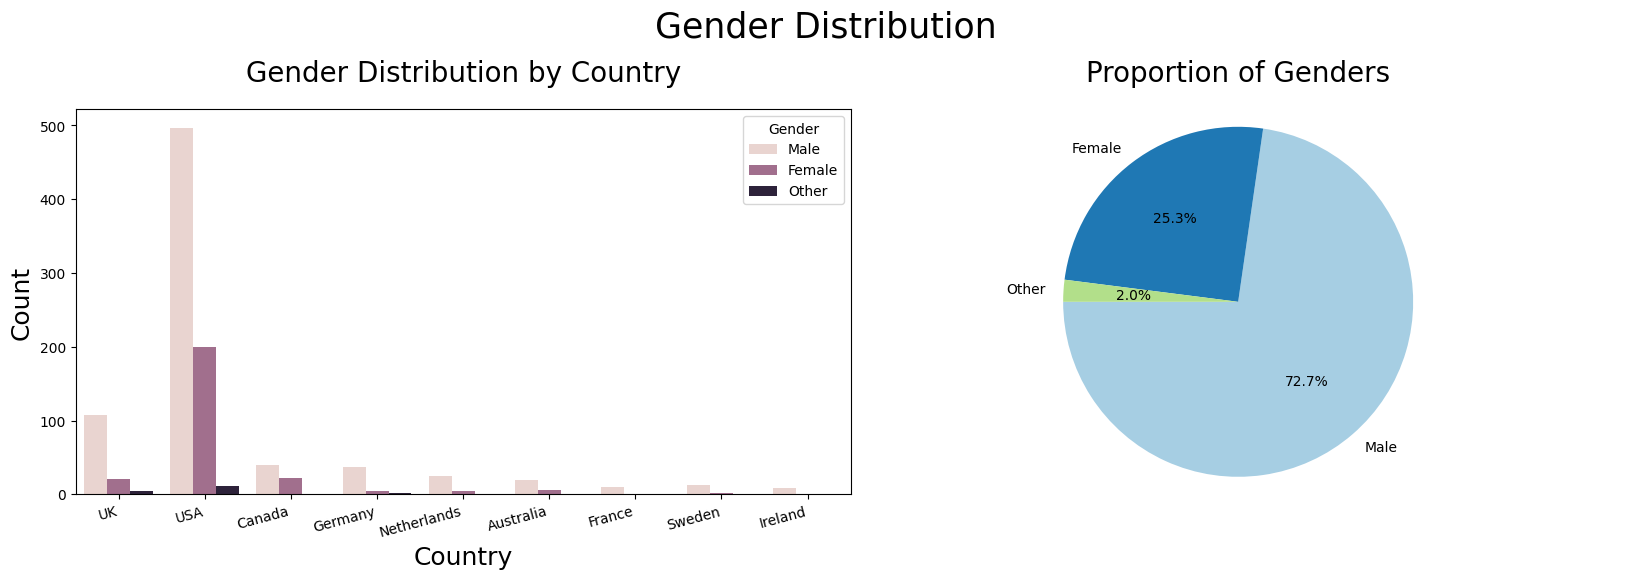

In [65]:
# Setting up the visualization for gender distribution in the entire dataset

# Create a main figure and set dimensions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
plt.subplots_adjust(wspace=0)
fig.suptitle('Gender Distribution', fontsize=25, y=1.08)

# Calculate proportions for the pie chart
total_respondents = workplace_data['sex'].count()
male_count = workplace_data[workplace_data['sex'] == 1.0]['sex'].count()
female_count = workplace_data[workplace_data['sex'] == 2.0]['sex'].count()
other_count = workplace_data[workplace_data['sex'] == 3.0]['sex'].count()

# Labels and colors for the chart
gender_labels = ['Male', 'Female', 'Other']
gender_sizes = [male_count/total_respondents, female_count/total_respondents, other_count/total_respondents]
explode_settings = (0.03, 0, 0)  

# Creating a pie chart
ax2.pie(gender_sizes, labels=gender_labels, autopct='%1.1f%%', startangle=180)
ax2.axis('equal') 
ax2.set_title('Proportion of Genders', pad=20, fontsize=20)

# Creating a bar chart for gender distribution by country
sns.countplot(x='country_of_residence', hue='sex', data=workplace_data, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")
ax1.set_title('Gender Distribution by Country', pad=20, fontsize=20)
ax1.set_xlabel('Country', fontsize=18)
ax1.set_ylabel('Count', fontsize=18)
ax1.legend(['Male', 'Female', 'Other'], title='Gender')


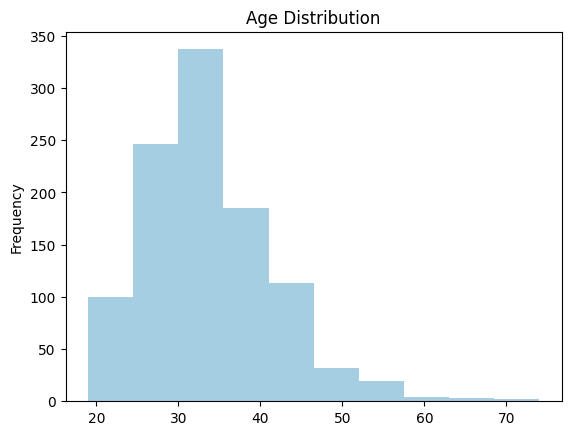

In [36]:
plt.hist(workplace_data['age']) 
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.show()


C:\Users\daiym\AppData\Local\Temp\ipykernel_3060\2502523899.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis1.set_xticklabels(axis1.get_xticklabels(), rotation=15, ha="right")
C:\Users\daiym\AppData\Local\Temp\ipykernel_3060\2502523899.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis2.set_xticklabels(axis2.get_xticklabels(), rotation=15, ha="right")


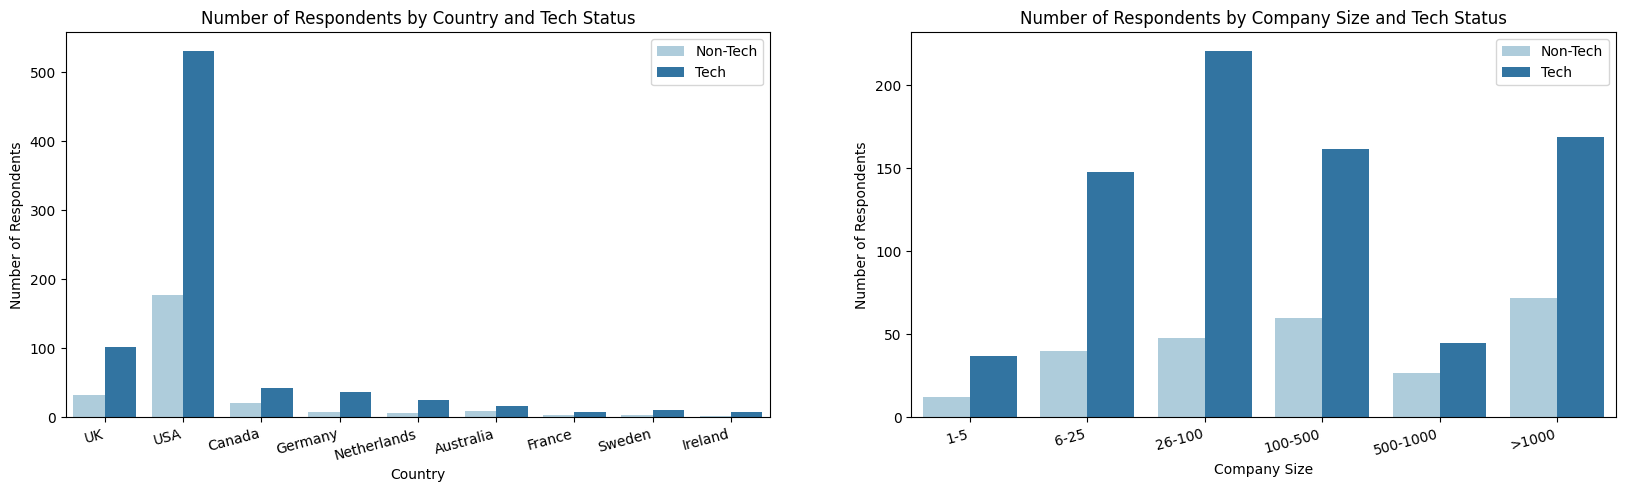

<Figure size 1600x400 with 0 Axes>

In [37]:
# The majority of respondents work in tech, and most are based in the US.
# Tech professionals are predominantly employed in medium to large companies.
# For the purposes of this analysis, which focuses on mental health in the tech industry, non-tech respondents will be excluded.

# Set up the plot layout with two subplots side by side
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2)
plt.figure(figsize=(16, 4))
fig.set_figheight(5)
fig.set_figwidth(20)
plt.subplots_adjust(wspace=0)

# Plot the number of respondents by country, distinguishing between tech and non-tech
sns.countplot(x=workplace_data['country_of_residence'], hue=workplace_data['tech_flag'], ax=axis1)
axis1.set_title('Number of Respondents by Country and Tech Status')
axis1.set_xticklabels(axis1.get_xticklabels(), rotation=15, ha="right")
axis1.set_xlabel('Country')
axis1.set_ylabel('Number of Respondents')
axis1.legend(['Non-Tech', 'Tech'])

# Plot the number of respondents by company size, distinguishing between tech and non-tech
sns.countplot(x=workplace_data['company_size'], hue=workplace_data['tech_flag'], ax=axis2,
              order=['1-5', '6-25', '26-100', '100-500', '500-1000', '>1000'])
axis2.set_title('Number of Respondents by Company Size and Tech Status')
axis2.set_xticklabels(axis2.get_xticklabels(), rotation=15, ha="right")
axis2.set_xlabel('Company Size')
axis2.set_ylabel('Number of Respondents')
axis2.legend(['Non-Tech', 'Tech'])


In [68]:
# Calculate the total number of respondents in each category (Tech vs. Non-Tech)
total_counts = workplace_data['tech_flag'].value_counts()

# Calculate the percentages for Tech and Non-Tech respondents
tech_percentage = (total_counts[1] / total_counts.sum()) * 100  # Assuming '1' is for Tech
non_tech_percentage = (total_counts[0] / total_counts.sum()) * 100  # Assuming '0' is for Non-Tech

# Print the results
print(f"Percentage of Tech respondents: {tech_percentage:.2f}%")
print(f"Percentage of Non-Tech respondents: {non_tech_percentage:.2f}%")


Percentage of Tech respondents: 75.12%
Percentage of Non-Tech respondents: 24.88%


### Types of Enployment
The part chart below shows the types of employment of participants. 

However, one drawback of the questionnaire is that for participant who answered "yes" to the question "Is your employer primarily a tech company/organization?", they weren't required to answer the question "Is your primary role within your company related to tech/IT?"

Therefore, it can't be distinguished participants in tech companies were of tech roles or non-tech roles. 

### Types of Mental Health Disorders

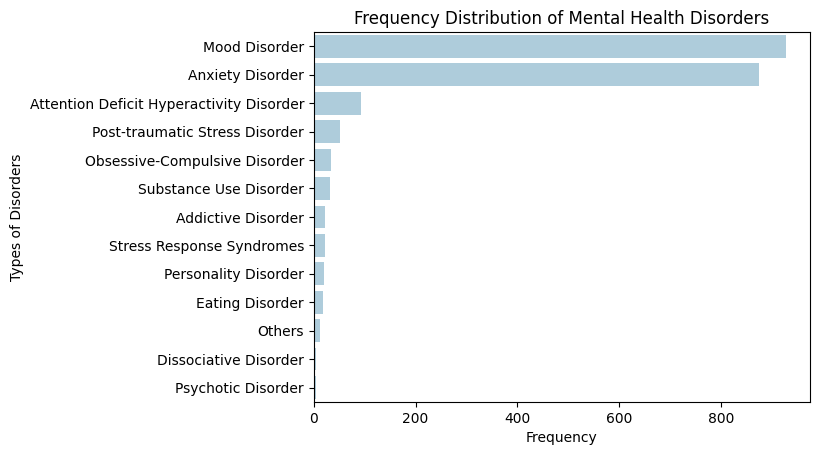

In [76]:
# Set up the disorder tracking dictionary
unique_disorders = {}

# Calculate counts for each disorder, including cases with multiple disorders per response
counts = workplace_data['diagnosis_details'].dropna().value_counts()
for ori_names, total in counts.items():
    sep_names = ori_names.split('|')
    for individual_disorder in sep_names:
        simplified_disorder = individual_disorder.split(' (')[0].strip()
        unique_disorders[simplified_disorder] = unique_disorders.get(simplified_disorder, 0) + total

# Convert the dictionary to a DataFrame
mental_disorder_df = pd.DataFrame(list(unique_disorders.items()), columns=['DisorderType', 'Frequency'])

# Standardize disorder names to unify similar categories
disorder_name_mapping = {
    'Autism Spectrum Disorder': 'Autism', 
    'Autism - while not a "mental illness", still greatly affects how I handle anxiety': 'Autism',
    'autism spectrum disorder': 'Autism', 
    'PDD-NOS': 'Autism',
    'Aspergers': "Asperger's Syndrome", 
    'Asperger Syndrome': "Asperger's Syndrome",
    'posttraumatic stress disourder': 'Post-traumatic Stress Disorder',
    'ADD': 'Attention Deficit Hyperactivity Disorder', 
    'Attention Deficit Disorder': 'Attention Deficit Hyperactivity Disorder',
    'attention deficit disorder': 'Attention Deficit Hyperactivity Disorder',
    'Schizotypal Personality Disorder': 'Personality Disorder',
    'Depression': 'Mood Disorder'
}

mental_disorder_df['DisorderType'] = mental_disorder_df['DisorderType'].replace(disorder_name_mapping)

# Define a list of common disorders to aggregate other types
established_disorder_types = [
    'Mood Disorder', 'Anxiety Disorder', 'Attention Deficit Hyperactivity Disorder',
    'Post-traumatic Stress Disorder', 'Obsessive-Compulsive Disorder',
    'Stress Response Syndromes', 'Personality Disorder', 'Substance Use Disorder',
    'Eating Disorder', 'Addictive Disorder', 'Dissociative Disorder', 
    'Psychotic Disorder', 'Others'  # Added 'Others' here to ensure it's included in the sorting process
]

# Consolidate infrequent disorders into 'Others' category
mental_disorder_df['DisorderType'] = mental_disorder_df['DisorderType'].apply(
    lambda disorder: disorder if disorder in established_disorder_types else 'Others'
)

# Aggregate the frequencies post name replacement and sort in descending order
final_disorder_counts = mental_disorder_df.groupby('DisorderType').sum().reset_index()
final_disorder_counts = final_disorder_counts.sort_values(by='Frequency', ascending=False)  # Sorting step

# Visualization of the disorder frequencies in descending order
sns.barplot(data=final_disorder_counts, y='DisorderType', x='Frequency')
plt.ylabel('Types of Disorders')
plt.title('Frequency Distribution of Mental Health Disorders')
plt.show()


In [70]:
# Calculate total count of all disorders for percentage calculation
total_disorder_count = final_disorder_counts['Frequency'].sum()

# Calculate the percentage for each disorder type
final_disorder_counts['Percentage'] = (final_disorder_counts['Frequency'] / total_disorder_count) * 100
print(final_disorder_counts[['DisorderType', 'Percentage']])


                                DisorderType  Percentage
5                              Mood Disorder   43.856333
1                           Anxiety Disorder   41.304348
2   Attention Deficit Hyperactivity Disorder    4.347826
9             Post-traumatic Stress Disorder    2.410208
6              Obsessive-Compulsive Disorder    1.606805
12                    Substance Use Disorder    1.465028
0                         Addictive Disorder    1.086957
11                 Stress Response Syndromes    1.086957
8                       Personality Disorder    0.945180
4                            Eating Disorder    0.897921
7                                     Others    0.567108
3                      Dissociative Disorder    0.236295
10                        Psychotic Disorder    0.189036


<Figure size 1600x500 with 0 Axes>

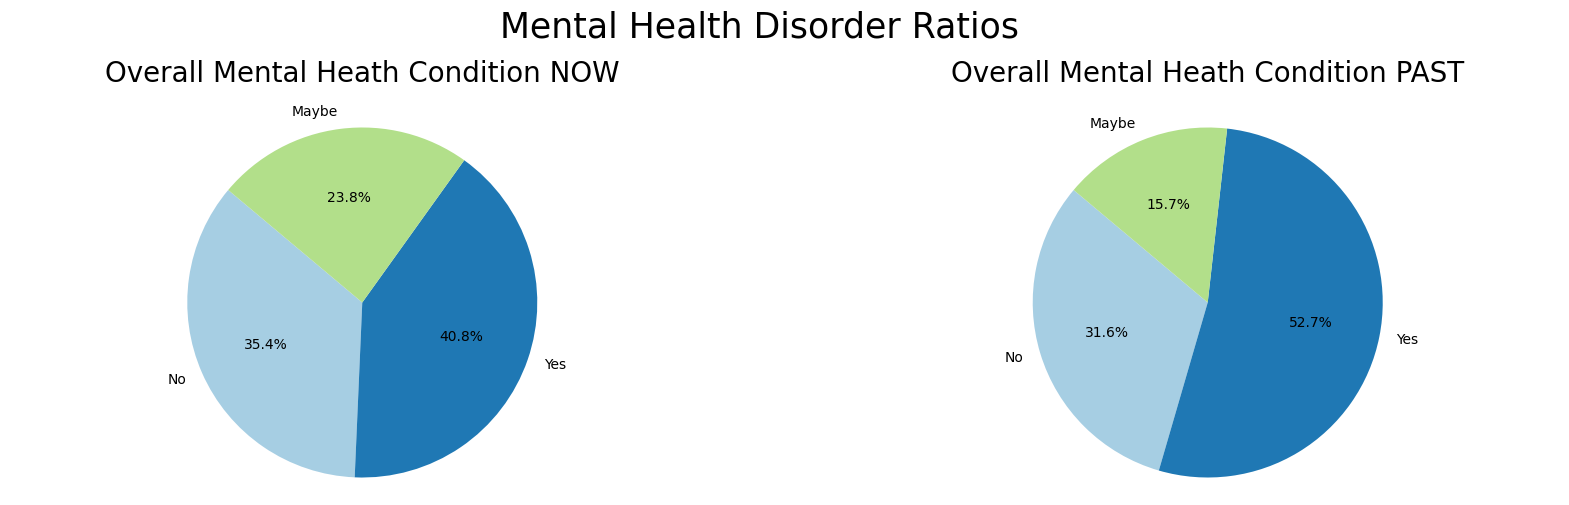

In [77]:
# Set up the figure for plotting
plt.figure(figsize=(16, 5))
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(20)
fig.suptitle('Mental Health Disorder Ratios', fontsize=25, y=1.08)


# Data filtering
tech_data_now = workplace_data[workplace_data['tech_flag'] == 1]  # Filter for tech-related roles
all_techs_now = tech_data_now['current_mental_disorder'].count()

# Count the occurrences for 'Yes', 'No', 'Maybe'
no_now = tech_data_now[tech_data_now['current_mental_disorder'] == 'No']['current_mental_disorder'].count()
yes_now = tech_data_now[tech_data_now['current_mental_disorder'] == 'Yes']['current_mental_disorder'].count()
maybe_now = tech_data_now[tech_data_now['current_mental_disorder'] == 'Maybe']['current_mental_disorder'].count()

# Pie Chart (Now)
labels = ['No', 'Yes', 'Maybe']
sizes = [no_now / all_techs_now, yes_now / all_techs_now, maybe_now / all_techs_now]


ax1.pie(sizes, labels=labels, autopct='%1.1f%%',  startangle=140)
ax1.axis('equal')
ax1.set_title('Overall Mental Heath Condition NOW', pad=20, fontsize=20)

# If you want to plot another pie chart for comparison, you can adjust the data accordingly
# For example, you could plot data for past mental health conditions, etc.

# Placeholder for second pie chart (you can adjust this section according to your needs)
past_mental_disorder_data = workplace_data['past_mental_disorder']  # Assuming you have this column
all_techs_past = past_mental_disorder_data.count()

# Count occurrences for 'Yes', 'No', 'Maybe' in the past
no_past = past_mental_disorder_data[past_mental_disorder_data == 'No'].count()
yes_past = past_mental_disorder_data[past_mental_disorder_data == 'Yes'].count()
maybe_past = past_mental_disorder_data[past_mental_disorder_data == 'Maybe'].count()

# Pie Chart (Past)
sizes_past = [no_past / all_techs_past, yes_past / all_techs_past, maybe_past / all_techs_past]
ax2.pie(sizes_past, labels=labels, autopct='%1.1f%%', startangle=140)
ax2.axis('equal')
ax2.set_title('Overall Mental Heath Condition PAST', pad=20, fontsize=20)

plt.show()


C:\Users\daiym\AppData\Local\Temp\ipykernel_3060\1746469084.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")
C:\Users\daiym\AppData\Local\Temp\ipykernel_3060\1746469084.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=15, ha="right")


<Figure size 1600x500 with 0 Axes>

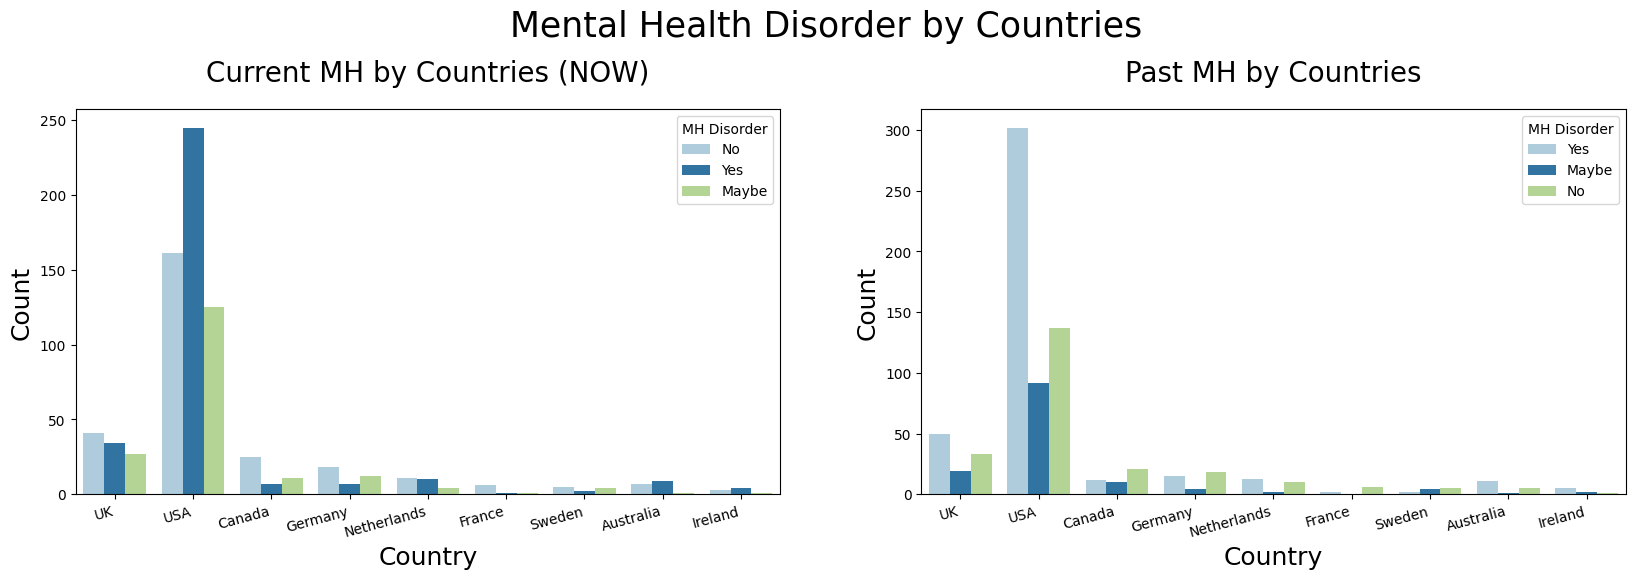

In [40]:
# Set up the figure for plotting
plt.figure(figsize=(16, 5))
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(20)
fig.suptitle('Mental Health Disorder by Countries', fontsize=25, y=1.08)

# Barchart for current mental health disorder by country (now)
sns.countplot(x=workplace_data[workplace_data['tech_flag'] == 1]['country_of_residence'], 
              hue=workplace_data['current_mental_disorder'], ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")
ax1.set_title('Current MH by Countries (NOW)', pad=20, fontsize=20)
ax1.set_xlabel('Country', fontsize=18)
ax1.set_ylabel('Count', fontsize=18)
ax1.legend(title='MH Disorder', loc='upper right')

# Barchart for past mental health disorder by country (past)
sns.countplot(x=workplace_data[workplace_data['tech_flag'] == 1]['country_of_residence'], 
              hue=workplace_data['past_mental_disorder'], ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=15, ha="right")
ax2.set_title('Past MH by Countries', pad=20, fontsize=20)
ax2.set_xlabel('Country', fontsize=18)
ax2.set_ylabel('Count', fontsize=18)
ax2.legend(title='MH Disorder', loc='upper right')

plt.show()


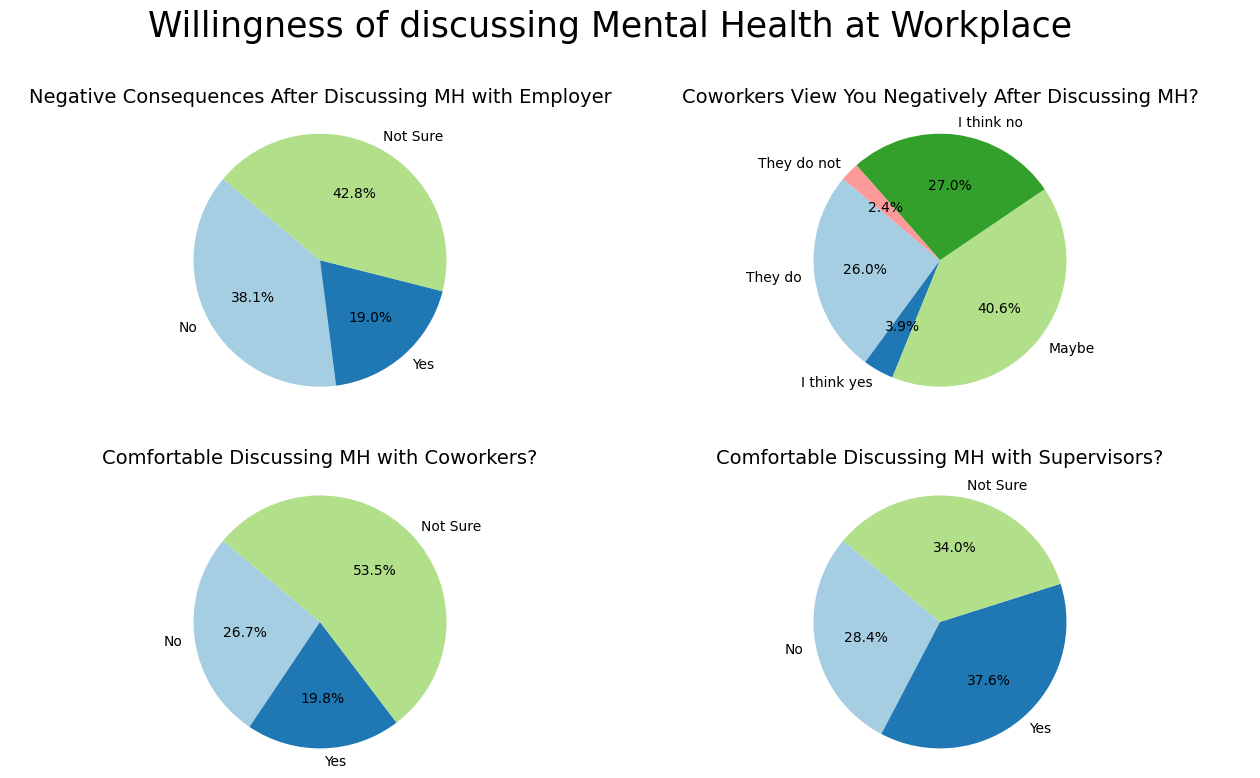

In [41]:
# Set up the figure for plotting
fig, axes = plt.subplots(figsize=(16, 8), ncols=2, nrows=2)
plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top=0.9, wspace=0, hspace=0.3)
plt.suptitle('Willingness of discussing Mental Health at Workplace', fontsize=25, y=1.04)



# Pie chart 1: Negative consequences of discussing mental health with employer
total_responses = workplace_data['discussion_negative_impact_flag'].count()
no_count = workplace_data[workplace_data['discussion_negative_impact_flag'] == 'No']['discussion_negative_impact_flag'].count()
yes_count = workplace_data[workplace_data['discussion_negative_impact_flag'] == 'Yes']['discussion_negative_impact_flag'].count()
maybe_count = workplace_data[workplace_data['discussion_negative_impact_flag'] == 'Maybe']['discussion_negative_impact_flag'].count()

labels = ['No', 'Yes', 'Not Sure']
sizes = [no_count / total_responses, yes_count / total_responses, maybe_count / total_responses]

axes[0, 0].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
axes[0, 0].axis('equal')
axes[0, 0].set_title('Negative Consequences After Discussing MH with Employer', pad=14, fontsize=14)

# Pie chart 2: Comfortable discussing mental health with coworkers
total_responses = imputed_data['coworker_discussion_flag'].count()
no_count = imputed_data[imputed_data['coworker_discussion_flag'] == 'No']['coworker_discussion_flag'].count()
yes_count = imputed_data[imputed_data['coworker_discussion_flag'] == 'Yes']['coworker_discussion_flag'].count()
maybe_count = imputed_data[imputed_data['coworker_discussion_flag'] == 'Maybe']['coworker_discussion_flag'].count()

sizes = [no_count / total_responses, yes_count / total_responses, maybe_count / total_responses]

axes[1, 0].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
axes[1, 0].axis('equal')
axes[1, 0].set_title('Comfortable Discussing MH with Coworkers?', pad=14, fontsize=14)

# Pie chart 3: Comfortable discussing mental health with supervisors
total_responses = workplace_data['supervisor_discussion_flag'].count()
no_count = workplace_data[workplace_data['supervisor_discussion_flag'] == 'No']['supervisor_discussion_flag'].count()
yes_count = workplace_data[workplace_data['supervisor_discussion_flag'] == 'Yes']['supervisor_discussion_flag'].count()
maybe_count = workplace_data[workplace_data['supervisor_discussion_flag'] == 'Maybe']['supervisor_discussion_flag'].count()

sizes = [no_count / total_responses, yes_count / total_responses, maybe_count / total_responses]


axes[1, 1].pie(sizes,  labels=labels, autopct='%1.1f%%', startangle=140)
axes[1, 1].axis('equal')
axes[1, 1].set_title('Comfortable Discussing MH with Supervisors?', pad=14, fontsize=14)


# Pie chart 4: Negative view by coworkers if they know about mental health disorder
total_responses = workplace_data['negative_view_coworkers'].count()
no_think_count = workplace_data[workplace_data['negative_view_coworkers'] == "No, I don't think they would"]['negative_view_coworkers'].count()
no_do_count = workplace_data[workplace_data['negative_view_coworkers'] == "No, they do not"]['negative_view_coworkers'].count()
maybe_count = workplace_data[workplace_data['negative_view_coworkers'] == 'Maybe']['negative_view_coworkers'].count()
yes_think_count = workplace_data[workplace_data['negative_view_coworkers'] == 'Yes, I think they would']['negative_view_coworkers'].count()
yes_do_count = workplace_data[workplace_data['negative_view_coworkers'] == 'Yes, they do']['negative_view_coworkers'].count()

labels = [ 'They do', 'I think yes', 'Maybe', 'I think no', 'They do not']
sizes = [
    no_think_count / total_responses,
    no_do_count / total_responses,
    maybe_count / total_responses,
    yes_think_count / total_responses,
    yes_do_count / total_responses
]

axes[0, 1].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
axes[0, 1].axis('equal')
axes[0, 1].set_title('Coworkers View You Negatively After Discussing MH?', pad=14, fontsize=14)

plt.show()



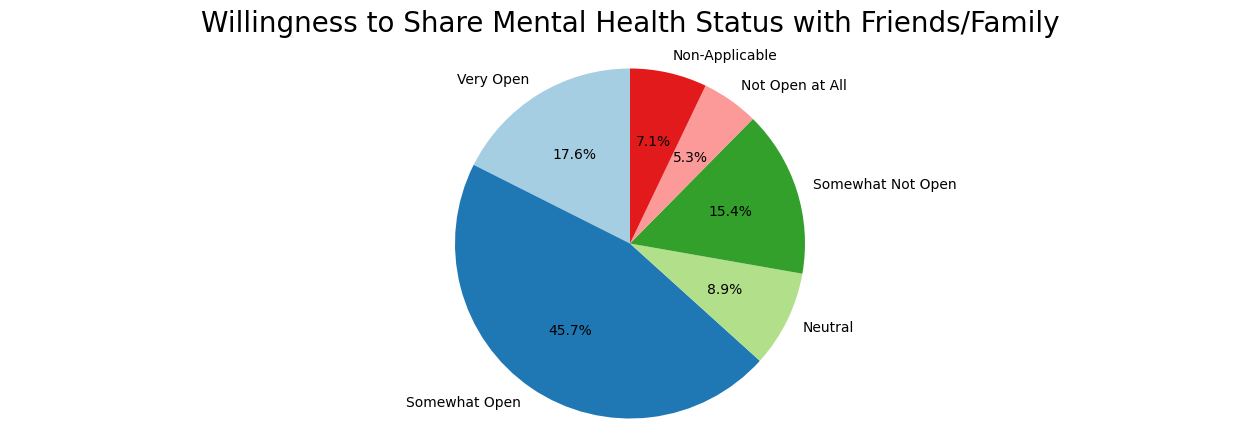

In [42]:
# Set up the figure for the pie chart
plt.figure(figsize=(16, 5))

# Filter the data for those in tech roles and calculate the counts for each response
total_responses = workplace_data['sharing_with_friends_family_flag'].count()
not_applicable = workplace_data[(workplace_data['sharing_with_friends_family_flag'] == "Not applicable to me (I do not have a mental illness)")]['sharing_with_friends_family_flag'].count()
not_open_at_all = workplace_data[(workplace_data['sharing_with_friends_family_flag'] == 'Not open at all')]['sharing_with_friends_family_flag'].count()
somewhat_not_open = workplace_data[(workplace_data['sharing_with_friends_family_flag'] == 'Somewhat not open')]['sharing_with_friends_family_flag'].count()
neutral = workplace_data[ (workplace_data['sharing_with_friends_family_flag'] == 'Neutral')]['sharing_with_friends_family_flag'].count()
somewhat_open = workplace_data[ (workplace_data['sharing_with_friends_family_flag'] == 'Somewhat open')]['sharing_with_friends_family_flag'].count()
very_open = workplace_data[ (workplace_data['sharing_with_friends_family_flag'] == 'Very open')]['sharing_with_friends_family_flag'].count()

# Define labels and sizes for the pie chart
labels = ['Very Open', 'Somewhat Open', 'Neutral', 'Somewhat Not Open', 'Not Open at All', 'Non-Applicable']
sizes = [very_open / total_responses, somewhat_open / total_responses, neutral / total_responses, somewhat_not_open / total_responses, not_open_at_all / total_responses,  not_applicable / total_responses]

# Plot the pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle= 90)
plt.axis('equal')
plt.title('Willingness to Share Mental Health Status with Friends/Family', pad=14, fontsize=20)
plt.show()


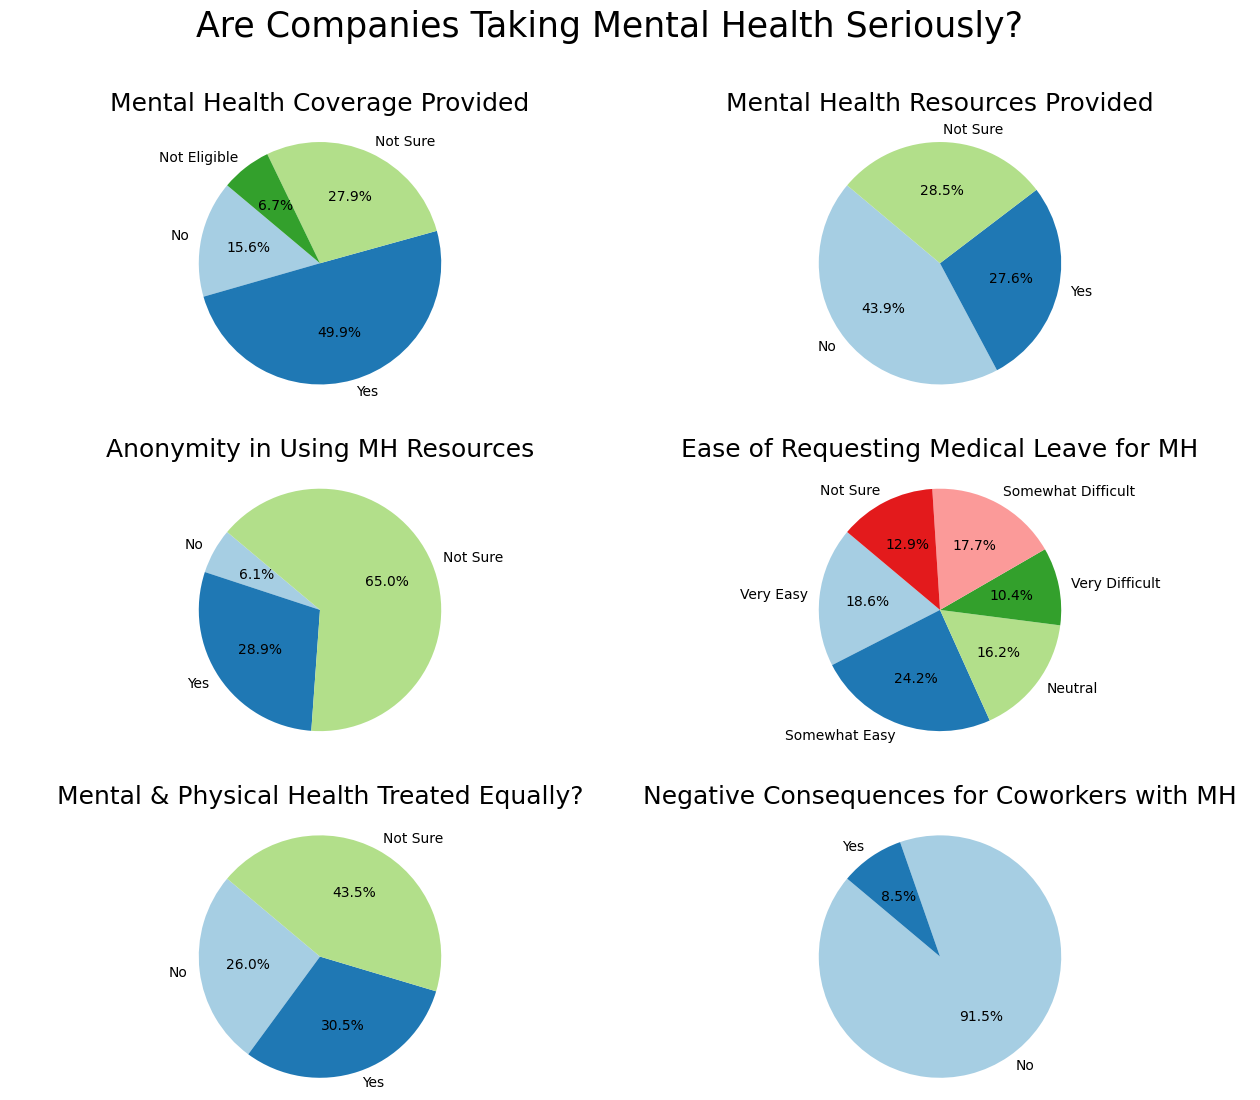

In [43]:
# Configure the plot size and layout
fig, axes = plt.subplots(figsize=(16, 12), ncols=2, nrows=3)
plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top=0.9, wspace=0, hspace=0.3)
plt.suptitle('Are Companies Taking Mental Health Seriously?', fontsize=25, y=1)

# Pie chart 1: Mental health coverage provided by employer
total_respondents = workplace_data['mental_health_coverage_flag'].count()
no_coverage = workplace_data[workplace_data['mental_health_coverage_flag'] == 'No']['mental_health_coverage_flag'].count()
yes_coverage = workplace_data[workplace_data['mental_health_coverage_flag'] == 'Yes']['mental_health_coverage_flag'].count()
unknown_coverage = workplace_data[workplace_data['mental_health_coverage_flag'] == "I don't know"]['mental_health_coverage_flag'].count()
not_eligible = workplace_data[workplace_data['mental_health_coverage_flag'] == 'Not eligible for coverage / N/A']['mental_health_coverage_flag'].count()

labels = ['No', 'Yes', 'Not Sure', 'Not Eligible']
sizes = [no_coverage / total_respondents, yes_coverage / total_respondents, unknown_coverage / total_respondents, not_eligible / total_respondents]

axes[0, 0].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
axes[0, 0].axis('equal')
axes[0, 0].set_title('Mental Health Coverage Provided', pad=14, fontsize=18)

# Pie chart 2: Resources provided by employer for mental health
total_respondents = workplace_data['resources_provided_flag'].count()
no_resources = workplace_data[workplace_data['resources_provided_flag'] == 'No']['resources_provided_flag'].count()
yes_resources = workplace_data[workplace_data['resources_provided_flag'] == 'Yes']['resources_provided_flag'].count()
unknown_resources = workplace_data[workplace_data['resources_provided_flag'] == "I don't know"]['resources_provided_flag'].count()

labels = ['No', 'Yes', 'Not Sure']
sizes = [no_resources / total_respondents, yes_resources / total_respondents, unknown_resources / total_respondents]

axes[0, 1].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
axes[0, 1].axis('equal')
axes[0, 1].set_title('Mental Health Resources Provided', pad=14, fontsize=18)

# Pie chart 3: Anonymity provided when using mental health resources
total_respondents = workplace_data['anonymity_flag'].count()
no_anonymity = workplace_data[workplace_data['anonymity_flag'] == 'No']['anonymity_flag'].count()
yes_anonymity = workplace_data[workplace_data['anonymity_flag'] == 'Yes']['anonymity_flag'].count()
unknown_anonymity = workplace_data[workplace_data['anonymity_flag'] == "I don't know"]['anonymity_flag'].count()

labels = ['No', 'Yes', 'Not Sure']
sizes = [no_anonymity / total_respondents, yes_anonymity / total_respondents, unknown_anonymity / total_respondents]

axes[1, 0].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
axes[1, 0].axis('equal')
axes[1, 0].set_title('Anonymity in Using MH Resources', pad=14, fontsize=18)

# Pie chart 4: Ease of requesting medical leave for mental health reasons
total_respondents = workplace_data['medical_leave_flag'].count()
very_easy = workplace_data[workplace_data['medical_leave_flag'] == 'Very easy']['medical_leave_flag'].count()
somewhat_easy = workplace_data[workplace_data['medical_leave_flag'] == 'Somewhat easy']['medical_leave_flag'].count()
neutral = workplace_data[workplace_data['medical_leave_flag'] == "Neither easy nor difficult"]['medical_leave_flag'].count()
very_difficult = workplace_data[workplace_data['medical_leave_flag'] == "Very difficult"]['medical_leave_flag'].count()
somewhat_difficult = workplace_data[workplace_data['medical_leave_flag'] == "Somewhat difficult"]['medical_leave_flag'].count()
unknown_difficulty = workplace_data[workplace_data['medical_leave_flag'] == "I don't know"]['medical_leave_flag'].count()

labels = ['Very Easy', 'Somewhat Easy', 'Neutral', 'Very Difficult', 'Somewhat Difficult', 'Not Sure']
sizes = [very_easy / total_respondents, somewhat_easy / total_respondents, neutral / total_respondents, very_difficult / total_respondents, somewhat_difficult / total_respondents, unknown_difficulty / total_respondents]

axes[1, 1].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
axes[1, 1].axis('equal')
axes[1, 1].set_title('Ease of Requesting Medical Leave for MH', pad=14, fontsize=18)

# Pie chart 5: Perception of employer's attitude towards mental vs physical health
total_respondents = workplace_data['employer_equal_mental_physical_health_flag'].count()
no_equal_treatment = workplace_data[workplace_data['employer_equal_mental_physical_health_flag'] == 'No']['employer_equal_mental_physical_health_flag'].count()
yes_equal_treatment = workplace_data[workplace_data['employer_equal_mental_physical_health_flag'] == 'Yes']['employer_equal_mental_physical_health_flag'].count()
unknown_equal_treatment = workplace_data[workplace_data['employer_equal_mental_physical_health_flag'] == "I don't know"]['employer_equal_mental_physical_health_flag'].count()

labels = ['No', 'Yes', 'Not Sure']
sizes = [no_equal_treatment / total_respondents, yes_equal_treatment / total_respondents, unknown_equal_treatment / total_respondents]

axes[2, 0].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
axes[2, 0].axis('equal')
axes[2, 0].set_title('Mental & Physical Health Treated Equally?', pad=14, fontsize=18)

# Pie chart 6: Observed negative consequences for coworkers being open about mental health
total_respondents = workplace_data['coworker_consequences_flag'].count()
no_negative_consequence = workplace_data[workplace_data['coworker_consequences_flag'] == 'No']['coworker_consequences_flag'].count()
yes_negative_consequence = workplace_data[workplace_data['coworker_consequences_flag'] == 'Yes']['coworker_consequences_flag'].count()

labels = ['No', 'Yes']
sizes = [no_negative_consequence / total_respondents, yes_negative_consequence / total_respondents]

axes[2, 1].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
axes[2, 1].axis('equal')
axes[2, 1].set_title('Negative Consequences for Coworkers with MH', pad=14, fontsize=18)

plt.show()


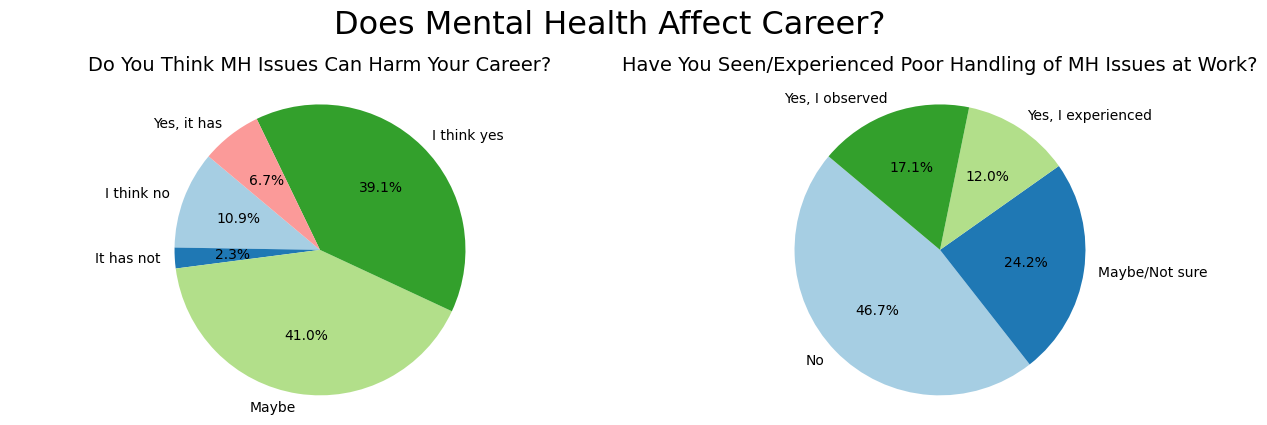

In [44]:
# Set up the figure and axes for plotting
fig, (ax1, ax2) = plt.subplots(figsize=(16, 4), ncols=2, nrows=1)
plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top=0.9, wspace=0, hspace=0.3)
plt.suptitle('Does Mental Health Affect Career?', fontsize=23, y=1.1)

# Pie chart 1: Impact of being identified as having a mental health issue on career
total_respondents = workplace_data['mental_health_career_impact'].count()
no_think = workplace_data[workplace_data['mental_health_career_impact'] == "No, I don't think it would"]['mental_health_career_impact'].count()
no_actual = workplace_data[workplace_data['mental_health_career_impact'] == "No, it has not"]['mental_health_career_impact'].count()
maybe = workplace_data[workplace_data['mental_health_career_impact'] == 'Maybe']['mental_health_career_impact'].count()
yes_think = workplace_data[workplace_data['mental_health_career_impact'] == 'Yes, I think it would']['mental_health_career_impact'].count()
yes_actual = workplace_data[workplace_data['mental_health_career_impact'] == 'Yes, it has']['mental_health_career_impact'].count()

labels = ['I think no', 'It has not', 'Maybe', 'I think yes', 'Yes, it has']
sizes = [no_think / total_respondents, no_actual / total_respondents, maybe / total_respondents, yes_think / total_respondents, yes_actual / total_respondents]

ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
ax1.axis('equal')
ax1.set_title('Do You Think MH Issues Can Harm Your Career?', pad=14, fontsize=14)

# Pie chart 2: Observations of unsupportive or poorly handled responses to mental health issues at work
total_respondents = workplace_data['bad_response_workplace'].count()
no_response = workplace_data[workplace_data['bad_response_workplace'] == "No"]['bad_response_workplace'].count()
maybe_response = workplace_data[workplace_data['bad_response_workplace'] == 'Maybe/Not sure']['bad_response_workplace'].count()
yes_experienced = workplace_data[workplace_data['bad_response_workplace'] == 'Yes, I experienced']['bad_response_workplace'].count()
yes_observed = workplace_data[workplace_data['bad_response_workplace'] == 'Yes, I observed']['bad_response_workplace'].count()

labels = ['No', 'Maybe/Not sure', 'Yes, I experienced', 'Yes, I observed']
sizes = [no_response / total_respondents, maybe_response / total_respondents, yes_experienced / total_respondents, yes_observed / total_respondents]

ax2.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
ax2.axis('equal')
ax2.set_title('Have You Seen/Experienced Poor Handling of MH Issues at Work?', pad=14, fontsize=14)

plt.show()


## Employees' Willingness to Talk about Mental Health and Physical Health Issues

In [ ]:

# Generate counts for each category of 'future_mental_health_specification' grouped by gender
grouped_counts_mental = workplace_data.groupby(['future_mental_health_specification', 'gender']).size().unstack(fill_value=0)

# Reorder DataFrame to ensure 'Yes', 'Maybe', 'No' on the x-axis
category_order = ['Yes', 'Maybe', 'No']
grouped_count_mental = grouped_counts_mental.reindex(category_order)

# Define colors for the genders
colors = {'Male': 'powderblue', 'Female': 'thistle', 'Other': 'mediumaquamarine'}

# Plot side-by-side bar charts
def plot_side_by_side_bars(grouped_count_mental, title):
    # Set up the figure and axis
    ax = grouped_count_mental.plot(kind='bar', figsize=(12, 7), color=[colors.get(x, 'gray') for x in grouped_counts_mental.columns])
    
    # Customize the plot
    plt.xlabel('Future Mental Health Specification')
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(rotation=0)  # Rotate x-axis labels to avoid overlap
    plt.legend(title='Gender')
    
    # Adjust x-axis ticks
    plt.tight_layout()
    plt.show()

# Plot the results
plot_side_by_side_bars(grouped_count_mental, 'Willingness of bringing up mental health issue with potential employer in an interview')



# Generate counts for each category of 'future_physical_health_specification' grouped by gender
grouped_counts_physical = data_2016.groupby(['future_physical_health_specification', 'gender']).size().unstack(fill_value=0)

grouped_count_physical = grouped_counts_physical.reindex(category_order)


# Plot side-by-side bar charts
def plot_side_by_side_bars(grouped_count_physical, title):
    # Set up the figure and axis
    ax = grouped_count_physical.plot(kind='bar', figsize=(12, 7), color=[colors.get(x, 'gray') for x in grouped_count_physical.columns])
    
    # Customize the plot
    plt.xlabel('Future Physical Health Specification')
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(rotation=0)  # Rotate x-axis labels to avoid overlap
    plt.legend(title='Gender')
    
    # Adjust x-axis ticks
    plt.tight_layout()
    plt.show()

# Plot the results
plot_side_by_side_bars(grouped_count_physical, 'Willingness of bringing up physical health issue with potential employer in an interview')



## Association between Mental Health Issues and Career

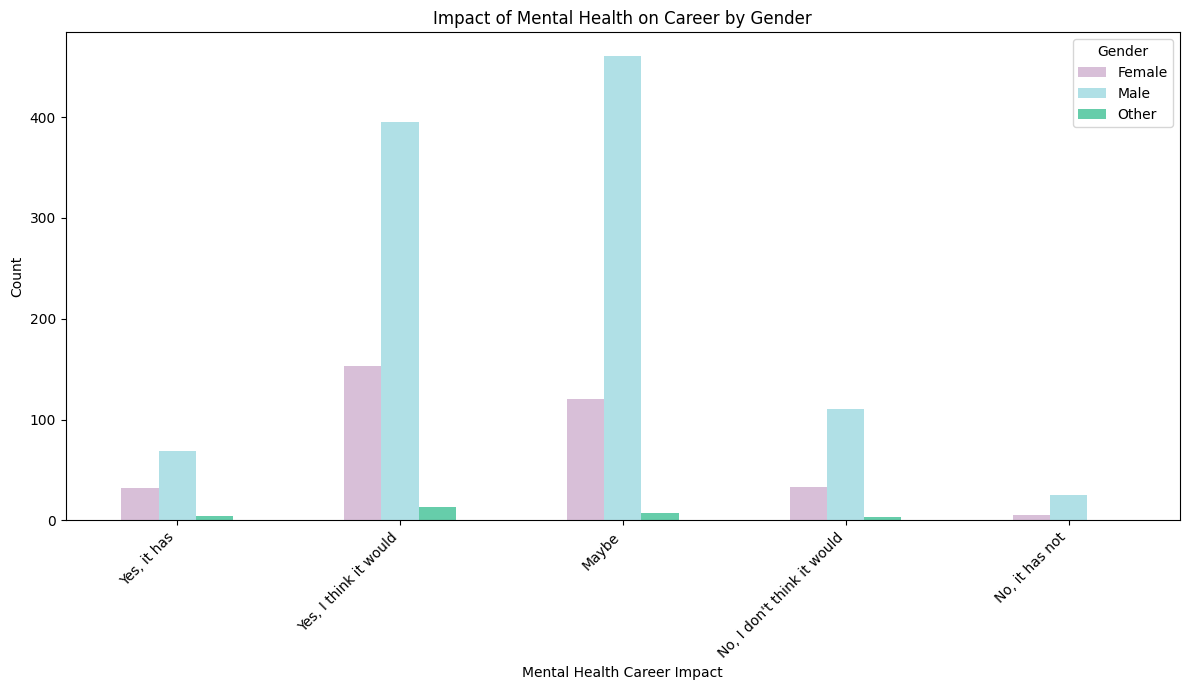

In [ ]:

# Generate counts for each category of 'mental_health_career_impact' grouped by gender
grouped_counts = data_2016.groupby(['mental_health_career_impact', 'gender']).size().unstack(fill_value=0)

# Reorder DataFrame to ensure categories are in a specific order
category_order = ['Yes, it has', 'Yes, I think it would', 'Maybe', 'No, I don\'t think it would', 'No, it has not']
grouped_counts = grouped_counts.reindex(category_order)

# Define colors for the genders
colors = {'Male': 'powderblue', 'Female': 'thistle', 'Other': 'mediumaquamarine'}

# Plot side-by-side bar charts
def plot_side_by_side_bars(grouped_counts, title):
    # Set up the figure and axis
    ax = grouped_counts.plot(kind='bar', figsize=(12, 7), color=[colors.get(x, 'gray') for x in grouped_counts.columns])
    
    # Customize the plot
    plt.xlabel('Mental Health Career Impact')
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.legend(title='Gender')
    
    # Adjust x-axis ticks
    plt.tight_layout()
    plt.show()

# Plot the results
plot_side_by_side_bars(grouped_counts, 'Belief in Mental Health Impact on Career')


## Association between Talking about Mental or Physical Health Issues with Emplpoyers 

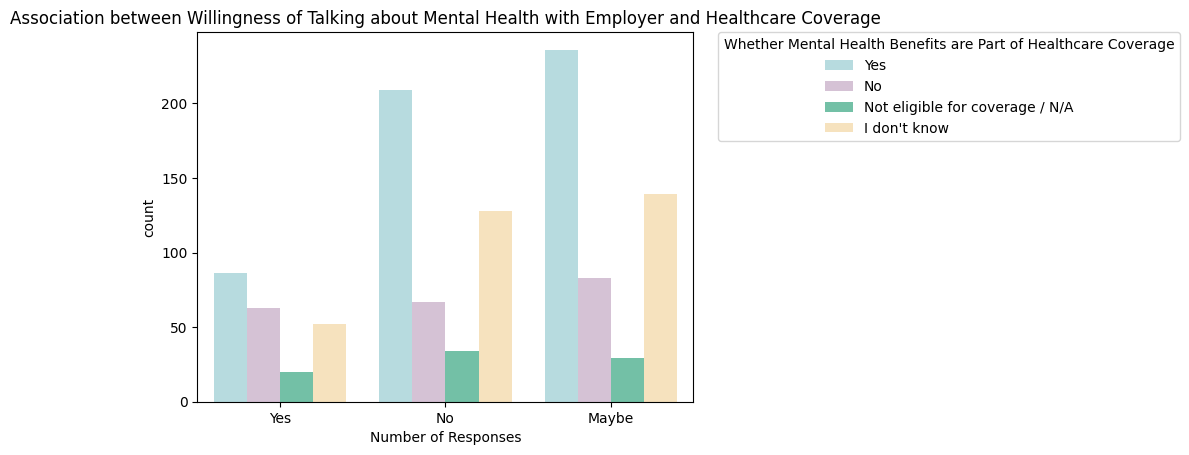

In [ ]:
colors = ['powderblue', 'thistle', 'mediumaquamarine', 'moccasin']
g = sns.countplot(x='discussion_negative_impact_flag',
                 hue='mental_health_coverage_flag',
                 data=data_2016, 
                 palette = colors,
                 order=['Yes', 'No', 'Maybe'],
                 hue_order=['Yes', 'No', 'Not eligible for coverage / N/A', "I don't know"])

plt.title('Association between Willingness of Talking about Mental Health with Employer and Healthcare Coverage')
plt.xlabel('Number of Responses')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,
         title='Whether Mental Health Benefits are Part of Healthcare Coverage')
plt.show()

## Work Productivity

C:\Users\daiym\AppData\Local\Temp\ipykernel_15536\592274209.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.countplot(x='productivity_impact',


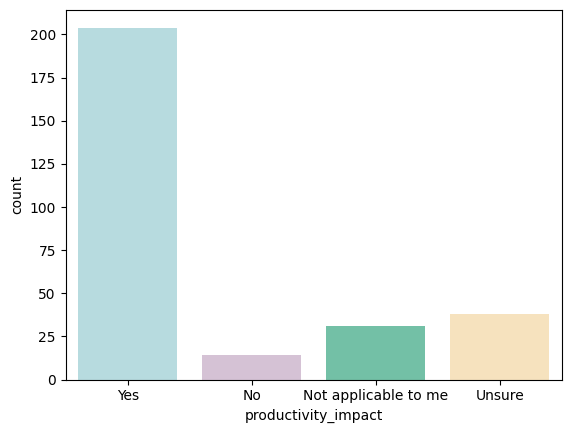

In [ ]:
colors = ['powderblue', 'thistle', 'mediumaquamarine', 'moccasin']

g = sns.countplot(x='productivity_impact',
                  data=data_2016, order=['Yes', 'No', 'Not applicable to me', 'Unsure'],
                  palette = colors,)
plt.show()



Procedure for Predicting 'current_mental_disorder' in a Data Science Project
Initial Data Preparation:

Exclude non-numeric columns to focus on features that can directly feed into machine learning models.
Split the dataset into feature variables (X) and the target variable (y), which is current_mental_disorder in this case.
Divide the data into training and testing sets for model validation.
Baseline Model Training and Evaluation:

Train a set of baseline models (e.g., Naive Bayes, KNN, Decision Trees, etc.) and evaluate them on the test set to get an initial sense of their performance using confusion matrices and accuracy scores.
Model Selection and Hyperparameter Tuning:

Select the best-performing models from the baseline evaluation.
Use Grid Search to fine-tune hyperparameters of the chosen models, with cross-validation, to improve accuracy.
Feature Importance Analysis:

After identifying the best model, use techniques like Permutation Importance to identify the most influential features for predicting current_mental_disorder.
Final Model Training with Selected Features:

Retrain the model using only the most important features identified in the previous step.
Evaluate the model on the test set and compare the accuracy with the initial results.
Top 10 Predictors Identification:

Identify the top 10 predictors for the current_mental_disorder and interpret their impact.

In [53]:
# Copy the data from combined_data for further processing
model_data = combined_data.copy()

# Ensure the correct DataFrame is used for filtering columns and include 'current_mental_disorder' explicitly
numeric_cols = [col for col in model_data.columns if model_data[col].dtype in ['int32', 'int64', 'float32', 'float64']]

# Apply the numeric columns filter
model_data = model_data[numeric_cols]

# Now directly extract the target variable and predictors
y = model_data['current_mental_disorder']
X = model_data.drop(columns=['current_mental_disorder'])

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


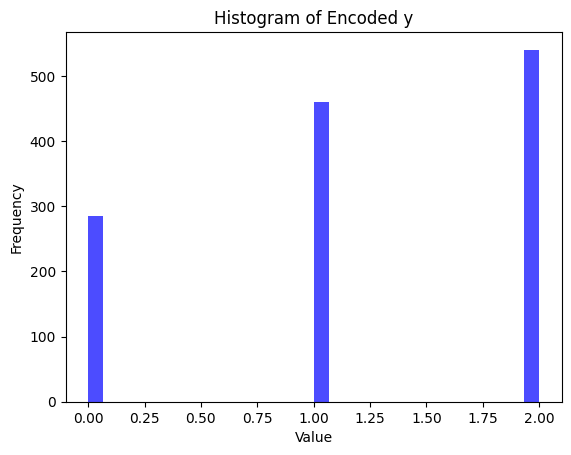

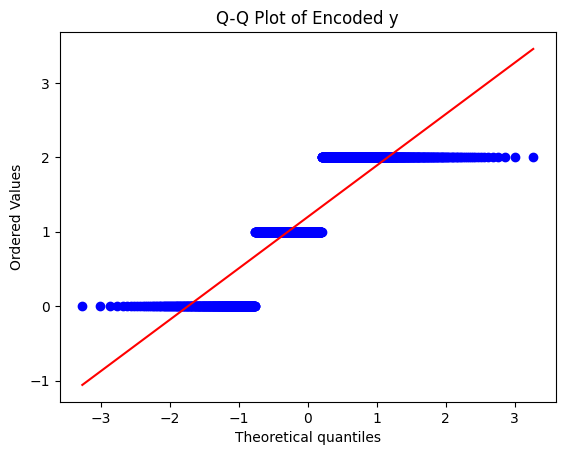

Shapiro-Wilk Test: Statistic=0.7863219976425171, p-value=5.060571361868028e-38


In [54]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# Histogram to visualize the distribution
plt.hist(y, bins=30, alpha=0.7, color='blue')
plt.title('Histogram of Encoded y')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# Q-Q plot to check for normality
stats.probplot(y, dist="norm", plot=plt)
plt.title('Q-Q Plot of Encoded y')
plt.show()

# Shapiro-Wilk Test for normality
shapiro_test = stats.shapiro(y)
print(f"Shapiro-Wilk Test: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")



In [55]:
def model_assess(model, X_train, y_train, X_test, y_test, name='Default'):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    accuracy = round(accuracy_score(y_test, preds), 5)
    print('---', name, '---')
    print(confusion_matrix(y_test, preds))
    print('Accuracy:', accuracy)
    return accuracy

    
# Dictionaries to store accuracies
accuracies_all_variables = {}


models = {
    'Naive Bayes': GaussianNB(),
    'SGD': SGDClassifier(max_iter=5000, random_state=0),
    'KNN': KNeighborsClassifier(n_neighbors=19),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0),
    'SVM': SVC(decision_function_shape="ovo"),
    'Logistic Regression': LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial'),
    'Neural Net': MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(150, 10), random_state=1),
    'XGBoost': XGBClassifier(n_estimators=1000, learning_rate=0.05),
    'XGBoost RF': XGBRFClassifier(objective='multi:softmax')
}


for name, model in models.items():
    accuracies_all_variables[name] = model_assess(model, X_train, y_train, X_test, y_test, name)

--- Naive Bayes ---
[[ 69  19   0]
 [  4 117   1]
 [  6  38 132]]
Accuracy: 0.82383
--- SGD ---
[[ 76   7   5]
 [  8  99  15]
 [  7   4 165]]
Accuracy: 0.88083
--- KNN ---
[[ 23  44  21]
 [  3 103  16]
 [  6   8 162]]
Accuracy: 0.74611
--- Decision Tree ---
[[ 77   8   3]
 [ 18  99   5]
 [  4  11 161]]
Accuracy: 0.87306
--- Random Forest ---
[[ 69  10   9]
 [  5  95  22]
 [  1   2 173]]
Accuracy: 0.87306
--- SVM ---
[[ 70  13   5]
 [  2 105  15]
 [  3   1 172]]
Accuracy: 0.89896


C:\Users\daiym\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--- Logistic Regression ---
[[ 75  10   3]
 [  5 105  12]
 [  5   7 164]]
Accuracy: 0.89119
--- Neural Net ---
[[ 73  11   4]
 [  8 102  12]
 [  7   9 160]]
Accuracy: 0.86788
--- XGBoost ---
[[ 76  10   2]
 [  7 107   8]
 [  4   4 168]]
Accuracy: 0.90933
--- XGBoost RF ---
[[ 74  13   1]
 [  5 114   3]
 [  2   8 166]]
Accuracy: 0.9171


In [ ]:


def gridSearch(parameters):
    # Use initial model parameters as defaults, ensuring they are included in the grid search
    stratified_k_fold = StratifiedKFold(n_splits=5)
                                        
    gsearch = GridSearchCV(
        estimator=XGBRFClassifier(
            learning_rate=0.05,  # Set to the initial value used in the original model
            n_estimators=1000,  # Consistent with your original model
            max_depth=10,       # Initial max_depth from the original model
            min_child_weight=1, # Lower bound of the grid search parameter
            gamma=0,            # Start with default gamma
            subsample=0.8,      # Initial value from your grid search setup
            colsample_bytree=0.8, # Initial value from your grid search setup
            objective='multi:softmax', # As per original model
            nthread=4           # Explicitly setting number of threads
        ),
        param_grid=parameters,
        cv=stratified_k_fold
    )
    gsearch.fit(X_train, y_train)
    print('Best params:', gsearch.best_params_)
    predictions = gsearch.predict(X_test)
    print('Accuracy:', round(accuracy_score(y_test, predictions), 5))

# Define the parameter grid explicitly including the initial values and exploring additional ones
gridSearch({
    'min_child_weight': [1, 2, 3, 4],
    'max_depth': [1, 5, 10]  
})
gridSearch({
    'gamma': [0, 0.1, 0.2, 0.3, 0.4]
})
gridSearch({
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9]
})
gridSearch({
    'learning_rate': [1e-5, 1e-2, 0.05, 0.1, 1]  
})


In [58]:
# Sorting indices based on feature names
sorted_indices = sorted(indices, key=lambda x: X_train.columns[x])

# Print the sorted list of top 50 features
sorted_feature_names = [X_train.columns[i] for i in sorted_indices]
print("Top 50 Features: ")
for feature in sorted_feature_names:
    print(feature)

Top 50 Features: 
anonymity_flag_No
condition_diagnosed_flag_Anxiety Disorder (Generalized, Social, Phobia, etc)|Mood Disorder (Depression, Bipolar Disorder, etc)
condition_diagnosed_flag_Attention Deficit Hyperactivity Disorder
condition_diagnosed_flag_Mood Disorder (Depression, Bipolar Disorder, etc)
coworker_discussion_flag_Yes
diagnosed_reveal_clients_impact_No
diagnosis_by_professional_Yes
diagnosis_details_Anxiety Disorder (Generalized, Social, Phobia, etc)
diagnosis_details_Anxiety Disorder (Generalized, Social, Phobia, etc)|Mood Disorder (Depression, Bipolar Disorder, etc)
diagnosis_details_Mood Disorder (Depression, Bipolar Disorder, etc)
effective_treatment_impact_on_work_Not applicable to me
effective_treatment_impact_on_work_Sometimes
employer_discussion_flag_No
employer_equal_mental_physical_health_flag_Yes
family_history_mental_health_No
family_history_mental_health_Yes
ineffective_treatment_impact_on_work_Not applicable to me
ineffective_treatment_impact_on_work_Often
in

In [59]:
# Copy the data from combined_data for further processing
filtered_model_data = combined_data.copy()

# Define the prefixes for the variables of interest
prefixes = [
    "anonymity_flag", "bad_response_workplace", "condition_diagnosed_flag", "coworker_discussion_flag",
    "diagnosis_by_professional", "diagnosis_details", "effective_treatment_impact_on_work",
    "employer_discussion_flag", "employer_equal_mental_physical_health_flag", "family_history_mental_health",
    "future_mental_health_specification", "ineffective_treatment_impact_on_work", "mental_health_career_impact",
    "past_mental_disorder", "physical_health_discussion_negative_impact_flag", "possible_diagnosis",
    "previous_coworker_discussion_flag", "previous_discussion_negative_consequences",
    "previous_employer_importance_mental_health", "previous_employers_flag", "previous_mental_health_benefits",
    "previous_mental_health_discussion", "previous_physical_health_discussion_negative_consequences",
    "previous_resources", "previous_supervisor_discussion_flag", "remote_work_flag", "sex",
    "sharing_with_friends_family_flag", "sought_professional_treatment", "tech_flag"
]


# Filter columns that start with any of the specified prefixes
filtered_columns = [col for col in filtered_model_data.columns if any(col.startswith(prefix) for prefix in prefixes)]

# Ensure to include 'current_mental_disorder' explicitly
filtered_columns.append('current_mental_disorder')

# Apply the filtered columns
filtered_model_data = filtered_model_data[filtered_columns]

# Now directly extract the target variable and predictors
y_filtered = filtered_model_data['current_mental_disorder']
X_filtered = filtered_model_data.drop(columns=['current_mental_disorder'])

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(X_filtered, y_filtered, test_size=0.3, random_state=42)


In [60]:
accuracies_filtered_variables = {}

def model_assess(model, X_train, y_train, X_test, y_test, name='Default'):
    # Train the model on the provided training data
    model.fit(X_train, y_train)
    # Make predictions on the testing data
    preds = model.predict(X_test)
    # Calculate accuracy
    accuracy = round(accuracy_score(y_test, preds), 5)
    # Output results
    print('---', name, '---')
    print(confusion_matrix(y_test, preds))
    print('Accuracy:', accuracy)
    # Return the accuracy for further use
    return accuracy

# Define models using the filtered data
models = {
    'Naive Bayes': GaussianNB(),
    'SGD': SGDClassifier(max_iter=5000, random_state=0),
    'KNN': KNeighborsClassifier(n_neighbors=19),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0),
    'SVM': SVC(decision_function_shape="ovo"),
    'Logistic Regression': LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial'),
    'Neural Net': MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(150, 10), random_state=1),
    'XGBoost': XGBClassifier(n_estimators=1000, learning_rate=0.05),
    'XGBoost RF': XGBRFClassifier(objective='multi:softmax')
}

    # Assess each model on filtered variables
for name, model in models.items():
    accuracies_filtered_variables[name] = model_assess(model, X_train_filtered, y_train_filtered, X_test_filtered, y_test_filtered, name)

--- Naive Bayes ---
[[ 69  19   0]
 [  3 118   1]
 [  4  40 132]]
Accuracy: 0.82642
--- SGD ---
[[ 78   8   2]
 [ 16 100   6]
 [  6   6 164]]
Accuracy: 0.88601
--- KNN ---
[[ 38  32  18]
 [  2 103  17]
 [  3   5 168]]
Accuracy: 0.80052
--- Decision Tree ---
[[ 77   9   2]
 [ 10 106   6]
 [  4  11 161]]
Accuracy: 0.89119
--- Random Forest ---
[[ 70  10   8]
 [  3  96  23]
 [  1   2 173]]
Accuracy: 0.87824
--- SVM ---
[[ 70  15   3]
 [  1 111  10]
 [  2   3 171]]
Accuracy: 0.91192


C:\Users\daiym\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--- Logistic Regression ---
[[ 73  12   3]
 [  6 108   8]
 [  5   8 163]]
Accuracy: 0.89119
--- Neural Net ---
[[ 73  10   5]
 [ 12 100  10]
 [  5   9 162]]
Accuracy: 0.86788
--- XGBoost ---
[[ 77   9   2]
 [  5 111   6]
 [  6   4 166]]
Accuracy: 0.9171
--- XGBoost RF ---
[[ 75  12   1]
 [  4 114   4]
 [  1   8 167]]
Accuracy: 0.92228


In [62]:
def gridSearch(parameters):
    stratified_k_fold = StratifiedKFold(n_splits=5)
    # Using the initial parameter values as defaults and setting up the grid search
    gsearch = GridSearchCV(
        estimator=XGBRFClassifier(
            learning_rate=0.05,  
            n_estimators=1000,  
            max_depth=10,      
            min_child_weight=1,
            gamma=0,            
            subsample=0.8,      
            colsample_bytree=0.8, 
            objective='multi:softmax',
            nthread=4           
        ), 
        param_grid=parameters, 
        cv=stratified_k_fold
    )
    gsearch.fit(X_train_filtered, y_train_filtered)
    print('Best params:', gsearch.best_params_)
    predictions = gsearch.predict(X_test_filtered)
    print('Accuracy:', round(accuracy_score(y_test_filtered, predictions), 5))

# Define a comprehensive set of parameter grids
gridSearch({
    'min_child_weight': [1, 2, 3, 4],
    'max_depth': [5, 10, 15, 20]  # Expanding beyond the initial setup
})
gridSearch({
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5]  # Including a wider range
})
gridSearch({
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],  # Full range for subsampling
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]  # Matching range for column sampling
})
gridSearch({
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1]  # Including and expanding around the initial value
})


Best params: {'max_depth': 10, 'min_child_weight': 4}
Accuracy: 0.91192
Best params: {'gamma': 0.1}
Accuracy: 0.91192
Best params: {'colsample_bytree': 1.0, 'subsample': 0.5}
Accuracy: 0.91969
Best params: {'learning_rate': 0.01}
Accuracy: 0.90933


Final Model Accuracy: 0.91451


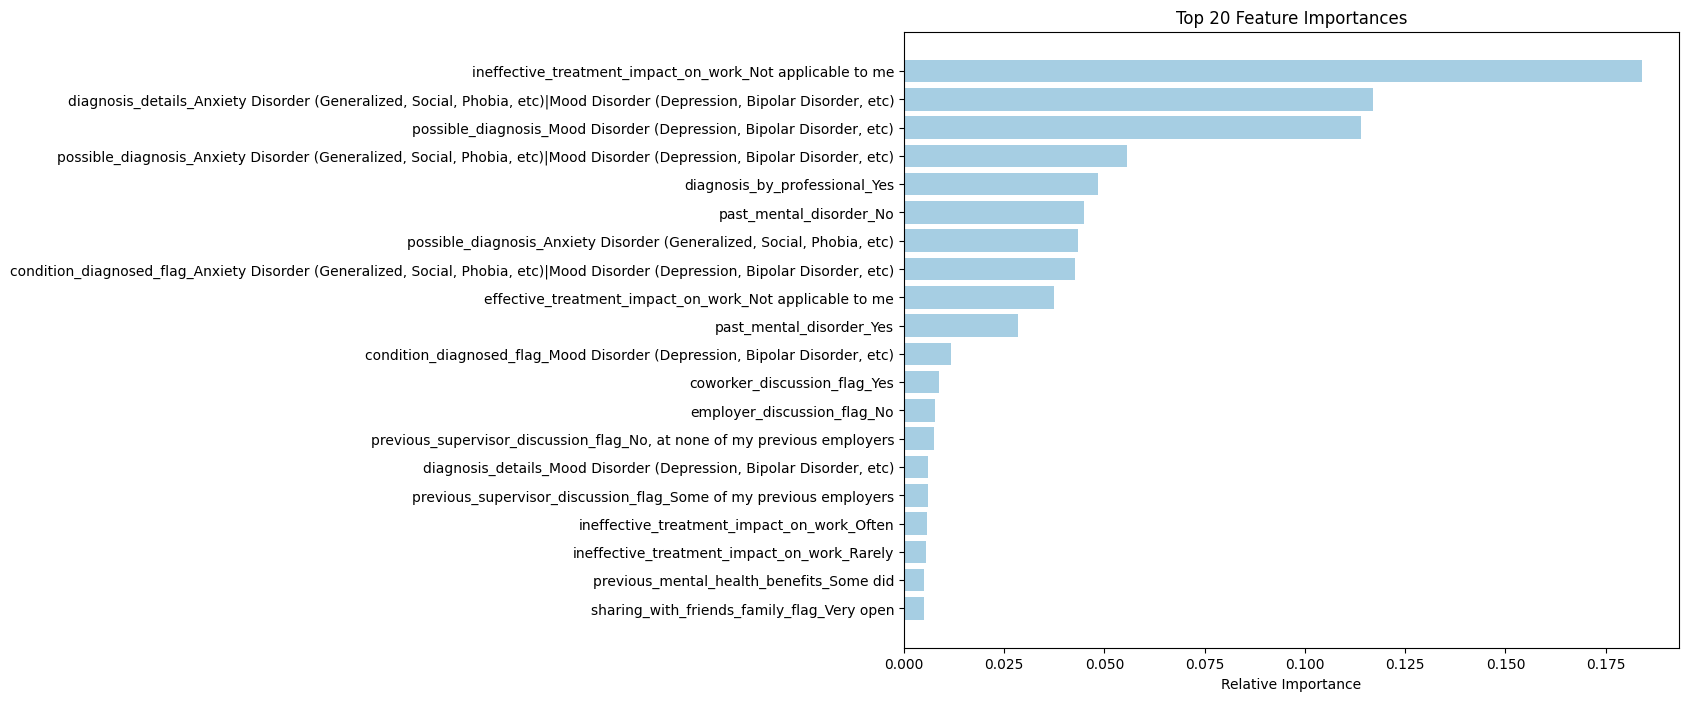

In [82]:
# Hypothetical optimal parameters from grid search
optimal_params = {
    'learning_rate': 0.01,  
    'n_estimators': 1000,
    'max_depth': 10,
    'min_child_weight': 4,
    'gamma': 0.1,
    'subsample': 0.5,
    'colsample_bytree': 1.0,
    'objective': 'multi:softmax'
}

# Train the final model with the optimized parameters
final_model = XGBRFClassifier(**optimal_params)
final_model.fit(X_train, y_train)

# Predictions to check final accuracy
final_preds = final_model.predict(X_test)
final_accuracy = accuracy_score(y_test, final_preds)
print(f'Final Model Accuracy: {final_accuracy:.5f}')



feature_importances = final_model.feature_importances_
indices = np.argsort(feature_importances)[-20:]  # Get the indices of the top 50 features

# Plot
plt.figure(figsize=(10, 8))
plt.title('Top 20 Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()



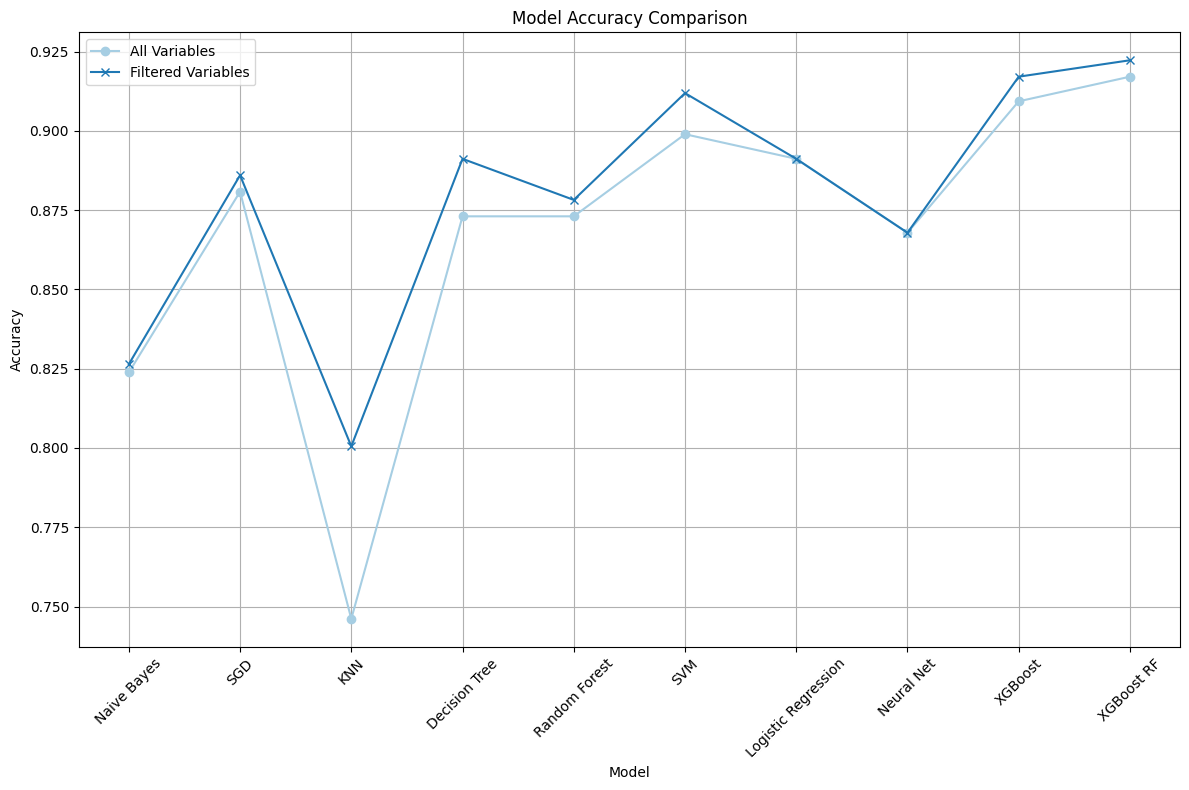

In [64]:

# Lists to hold data for plotting
model_names = list(models.keys())
accuracy_all = [accuracies_all_variables[name] for name in model_names]
accuracy_filtered = [accuracies_filtered_variables[name] for name in model_names]

# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(model_names, accuracy_all, label='All Variables', marker='o')
plt.plot(model_names, accuracy_filtered, label='Filtered Variables', marker='x')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
